# Preprocessing

Load DBS all channal data   
Bipolar referencing   
High pass filter    

setting for low and high pass
https://neurodsp-tools.github.io/neurodsp/generated/neurodsp.filt.filter_signal.html 

1. low pass filter at 250 hz
2. high pass filter at 0.1 hz
3. notch filter for line noise
4. downsample to 1000 hz (3 times above the LPF, read the reference https://en.wikipedia.org/wiki/Anti-aliasing_filter)
5. bipolar re-reference from shafts to rings
6. plot power spectrum 

In [1]:
import scipy
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series

In [2]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [89]:
# Specify root directory for un-archived data and results 
# base_dir = '/Users/fuq01' 
base_dir = '/sc/arion/projects/guLab/LEAP' 
# Specify subject names 
subj_ids = [701,702,705,706,814,815]

mat_dict = {f'{x}': [] for x in subj_ids}
elec_dict = {f'{x}': [] for x in subj_ids}

sub = 705

In [90]:
elec_dict

{'701': [], '702': [], '705': [], '706': [], '814': [], '815': []}

In [91]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

In [92]:
# all all subjects resting data pre-stim (one file for each subject)
for ids in subj_ids:
    sub_dir = f'{base_dir}/LFP/{sub}/intraop/pre_stim'
    mat_file = load_mat(glob.glob(f'{sub_dir}/resting*.mat')) #load resting LFP data only
    mat_dict[ids] = mat_file

In [93]:
# single patient data loading
# sub_dir = f'{base_dir}/Documents/GitHub/leap-analysis/LFP/data/702'
sub_dir = f'{base_dir}/LFP/{sub}/intraop/pre_stim'
mat_file = load_mat(glob.glob(f'{sub_dir}/resting*.mat')) #load resting LFP data only
example_data = mat_file[0]

In [96]:
# load final electrode sets
# sub_elec = pd.read_csv(f'{base_dir}/Documents/GitHub/leap-analysis/LFP/leap_TRD_coords.csv')
sub_elec = pd.read_csv(f'{base_dir}/Anat/leap_TRD_lfp_coords.csv')
example_sub = sub_elec[sub_elec['participant'].isin([sub])]
example_sub

,Unnamed: 0,index,participant,label,X,Y,Z,type,note,lfp_record,SenSight label,AO filtered,AO raw
7,7,7,705,Left E0,60.109887,70.665938,189.406710,native,gm,1,ring 3,CMacro LFP3,CMacro_RAW_03
8,8,8,705,Left E1 (a),58.043676,68.962142,190.906828,native,gm,1,seg 2C,CMacro LFP2,CMacro_RAW_02
9,9,9,705,Left E1 (b),58.451797,69.583555,191.752277,native,gm,1,seg 2B,CMacro LFP1,CMacro_RAW_01
10,10,10,705,Left E1 (c),57.635555,69.994443,191.094690,native,gm,1,seg 2A,CLFP5,CRAW_05
11,11,11,705,Left E2 (a),55.977466,67.809584,192.751383,native,gm,1,seg 1C,CLFP4,CRAW_04
12,12,12,705,Left E2 (b),56.385587,68.430997,193.596832,native,gm,1,seg 1B,CLFP3,CRAW_03
13,13,13,705,Left E2 (c),55.569345,68.841885,192.939246,native,gm,1,seg 1A,CLFP2,CRAW_02
14,14,14,705,Left E3,53.842382,67.169846,195.001861,native,wm,1,ring 0,CLFP1,CRAW_01


In [97]:
# wm electrode name
wm_elec_name = example_sub[example_sub['note'].isin(['wm'])].iloc[0]['AO raw']
wm_elec_name

'CRAW_01'

In [98]:
# grey matter electrode list (double check multiple gm list example patient)
# gm_elec_name = example_sub[~example_sub['note'].isin(['wm'])].iloc[0]['AO raw']
gm_df = example_sub[~example_sub['note'].isin(['wm'])]
gm_elec_name = example_sub[~example_sub['note'].isin(['wm'])]['AO raw'].to_list() #find all non wm electrode
gm_elec_name[0]

'CMacro_RAW_03'

In [118]:
# grey matter seg channals
gm_seg_1 = gm_df[gm_df['SenSight label'].str.contains('seg 1')]['AO raw'].to_list()
gm_seg_2 = gm_df[gm_df['SenSight label'].str.contains('seg 2')]['AO raw'].to_list()
gm_seg_2

['CMacro_RAW_02', 'CMacro_RAW_01', 'CRAW_05']

## preprocessing functions

In [10]:
def sig_flat(lfp, channel_name):
    fs = lfp[channel_name + '_KHz'].flatten()*1000
    fs = fs[0].astype(np.float32)
    sig = lfp[channel_name].flatten()
    return sig, fs

In [11]:
def downsample(lfp, hz, downsample_factor):
    '''
    Downsample signal by a factor of downsample_factor
    '''
    signal_ds = signal.decimate(lfp, downsample_factor)
    signal_hz = hz/downsample_factor
    if np.mod(hz, downsample_factor) != 0:
        raise ValueError('Sampling rate must be an integer after downsampling. Check your factor')
    return signal_ds, signal_hz

In [12]:
def add_buffer(sig, fs, n_seconds=2):
    """Add buffer to the beginning and end of a signal.
    Parameters
    ----------
    sig : 1d array
        Time series.
    fs : float
        Sampling rate, in Hz.
    n_seconds : float
        Buffer, in seconds, to add to the beginning and end of the signal.
    Returns
    -------
    sig_buffer : 1d array
        Time series with buffer.
    """

    n_buffer = int(fs * n_seconds)
    buff_pre = sig[0:n_buffer] # create pre-buffer index
    buff_post = sig[-n_buffer:] # create post-buffer index

    # append the buffer to the beginning and end of the signal
    sig_buffered = np.concatenate((buff_pre, sig, buff_post))

    return n_buffer, sig_buffered

In [13]:
def filters(sig, ds_hz, n_seconds=2):
    """Apply low/high/notch filter to a signal.
    Parameters
    ----------
    sig : 1d array
        Time series.
    fs : float
        Sampling rate, in Hz.
    n_seconds : float
        Buffer, in seconds, to add to the beginning and end of the signal.
    Returns
    -------
    sig_buffer : 1d array
        filtered time series.
    """
    n_buffer, sig_buffered = add_buffer(sig, ds_hz, n_seconds=n_seconds) #filter re-referenced signal
    low_pass = filter_signal(sig_buffered, fs=ds_hz, pass_type='lowpass', filter_type='fir', f_range=250, n_seconds=n_seconds, remove_edges=True)
    low_pass = low_pass[n_buffer:-n_buffer]

    n_buffer, sig_buffered = add_buffer(low_pass, ds_hz, n_seconds=n_seconds) 
    high_pass = filter_signal(sig_buffered, fs=ds_hz, pass_type='highpass', filter_type='fir', f_range=1, n_seconds=n_seconds, remove_edges=True)
    high_pass = high_pass[n_buffer:-n_buffer]

    n_buffer, sig_buffered = add_buffer(high_pass, ds_hz, n_seconds=n_seconds) 
    sig_filt_all = filter_signal(sig_buffered, ds_hz, 'bandstop', (58, 62), n_seconds=n_seconds, remove_edges=True)
    sig_filt_all = sig_filt_all[n_buffer:-n_buffer]
    
    return sig_filt_all

In [14]:
# visualize filtered signals
def filter_plot(sig, sig_filt, fs, plot_sec=20, sec_start=0):
    times = create_times(plot_sec, fs, start_val=0)
    lenth = int(fs*plot_sec)

    p_time = times[sec_start:lenth]
    p_raw = sig[sec_start:lenth]
    p_filt = sig_filt[sec_start:lenth]
    plot_time_series(p_time, [p_raw, p_filt], ['Raw', 'Filtered'])
    # plot_time_series(p_time, p_filt)

In [101]:
# grey matter seq average
def seg_average(seg):
    # seg: segment labels
    seg_list = []
    for seg in gm_seg:
        sig, fs = sig_flat(mat_dict[sub][0], seg)
        sig = sig.flatten()
        seg_list.append(sig)

    seg_ave = np.vstack(seg_list)
    sig_gm_seg = seg_ave.mean(0)
    return sig_gm_seg

In [119]:
seg_1_ave = seg_average(gm_seg_1)
seg_2_ave = seg_average(gm_seg_2)
seg_2_ave

array([106.        , 108.33333333, 106.        , ...,  17.66666667,
        13.33333333,  17.        ])

In [120]:
# re-referening
sig_gm, fs = sig_flat(mat_dict[sub][0], gm_elec_name[0]) #gm electrode first one
sig_wm, fs = sig_flat(mat_dict[sub][0], wm_elec_name) #wm electrode

# re-reference signal (single ring)
sig_ref = sig_gm - sig_wm
# re-reference signal (segment average)
sig_ref2 = seg_1_ave - sig_wm
sig_ref3 = seg_2_ave - sig_wm

In [16]:
# filter_plot(sig_gm, sig_ref, fs, plot_sec=20, sec_start=60)

In [121]:
ds_gm, ds_hz = downsample(sig_gm, fs, 44) #raw signal
ds_wm, ds_hz = downsample(sig_wm, fs, 44) #signal 2
ds_ref, ds_hz = downsample(sig_ref, fs, 44)

ds_seg_ref1, ds_hz = downsample(sig_ref2, fs, 44) # average of the segments 
ds_seg_ref2, ds_hz = downsample(sig_ref3, fs, 44) # average of the segments 

In [77]:
ds_seg_ave, ds_hz = downsample(sig_ref2, fs, 44) # average of the segments 

In [78]:
# filter_plot(ds_gm, ds_ref, ds_hz, plot_sec=20, sec_start=60)

In [107]:
sig_gm = filters(ds_gm, ds_hz)
sig_wm = filters(ds_wm, ds_hz)

In [122]:
sig_ref = filters(ds_ref, ds_hz)
sig_seg_ref1 = filters(ds_seg_ref1, ds_hz)
sig_seg_ref2 = filters(ds_seg_ref2, ds_hz)

In [21]:
elec_dict.update({str(701): sig_ref})
elec_dict

{'701': array([-1.0603533 , -1.17080408, -1.34086431, ..., -4.10786387,
        -3.4788341 , -6.56504558]),
 '702': [],
 '705': [],
 '706': [],
 '814': [],
 '815': []}

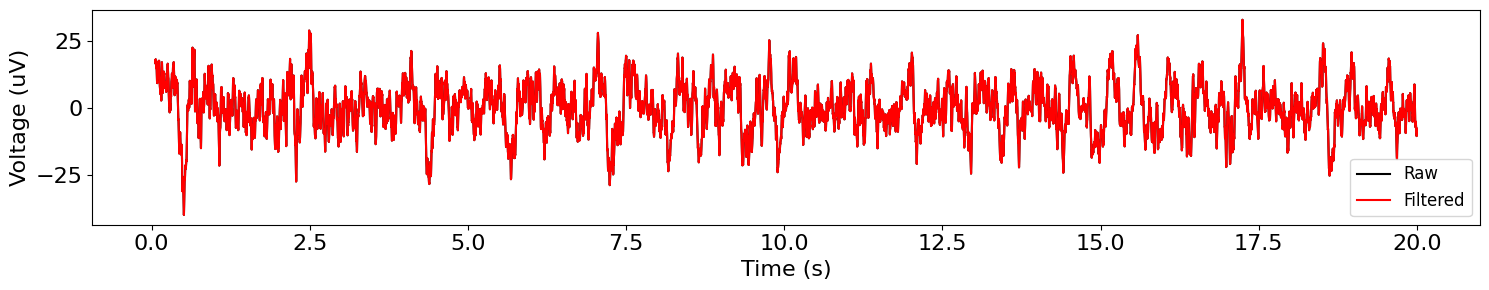

In [123]:
# downsample then filter version, double check plotting winder period (now it looks the same for start=0 and start=50)
filter_plot(sig_seg_ref1, sig_seg_ref2, ds_hz, plot_sec=20, sec_start=60)

# red filtered and re-referenced 

# Power spectrum examine

In [126]:
sig_seg_ref2

array([  6.61260528,  24.55716329,  25.35773223, ..., -15.93403847,
       -16.50582265,  -6.35959903])

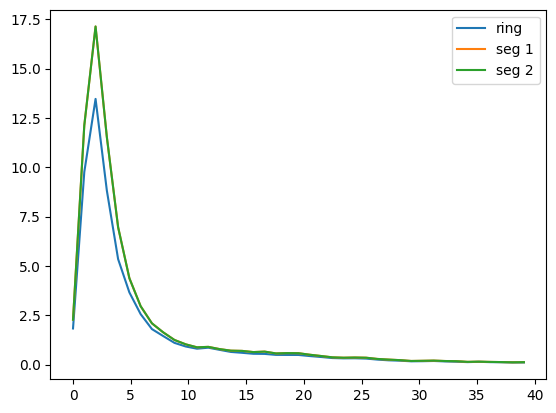

In [127]:
clean_sig = [sig_ref, sig_seg_ref1, sig_seg_ref2]
labels = ['ring', 'seg 1', 'seg 2']

for idx, sig in enumerate(clean_sig):
    freq_mean1, psd_mean1 = compute_spectrum(sig, ds_hz, method='welch', avg_type='mean', nperseg=1024)
    new_freq1 = freq_mean1[freq_mean1<40]
    new_psd1 = psd_mean1[freq_mean1<40]
    
    plt.plot(new_freq1, new_psd1, label=labels[idx])
    plt.legend()

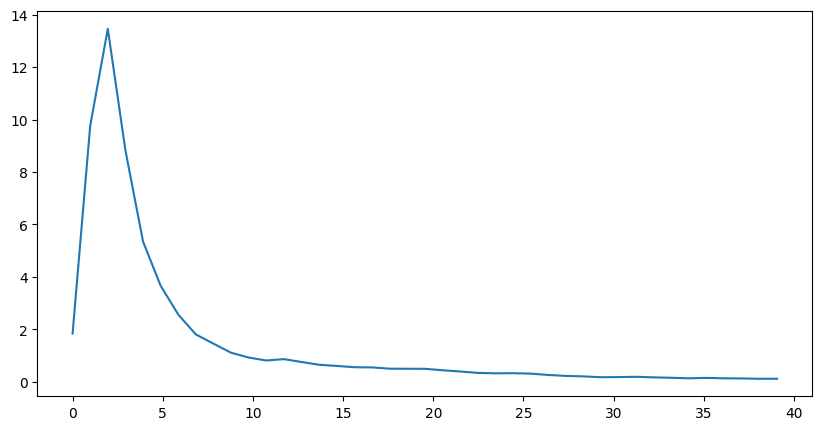

In [112]:
freq_mean1, psd_mean1 = compute_spectrum(sig_ref, ds_hz, method='welch', avg_type='mean', nperseg=1024)

new_freq1 = freq_mean1[freq_mean1<40]
new_psd1 = psd_mean1[freq_mean1<40]

plt.figure(figsize=(10, 5))
plt.plot(new_freq1, new_psd1, label='referenced_downsampled')

## older example 

fliter and then downsample version

In [21]:
# sig, fs = sig_flat(example_data, 'CRAW_01')
# c2, fs = sig_flat(example_data, 'CRAW_02')

In [12]:
# applying low/high/notch filter to the signal (~4m runtime)
n_seconds = 2

n_buffer, sig_buffered = add_buffer(c2, fs, n_seconds=n_seconds) 
low_pass = filter_signal(sig_buffered, fs=fs, pass_type='lowpass', filter_type='fir', f_range=250, n_seconds=n_seconds, remove_edges=True)
low_pass = low_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(low_pass, fs, n_seconds=n_seconds) 
high_pass = filter_signal(sig_buffered, fs=fs, pass_type='highpass', filter_type='fir', f_range=0.1, n_seconds=n_seconds, remove_edges=True)
high_pass = high_pass[n_buffer:-n_buffer]

n_buffer, sig_buffered = add_buffer(high_pass, fs, n_seconds=n_seconds) 
c2_filt = filter_signal(sig_buffered, fs, 'bandstop', (58, 62), n_seconds=n_seconds, remove_edges=True)
c2_filt = c2_filt[n_buffer:-n_buffer]

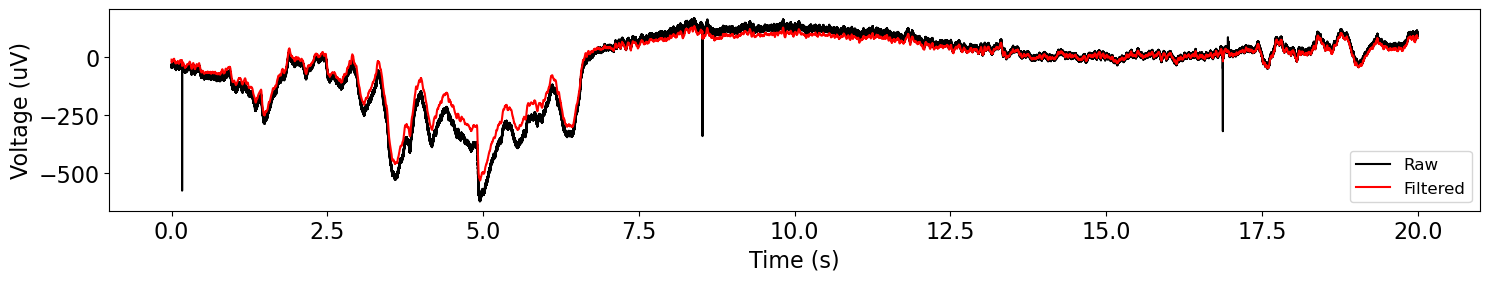

In [13]:
filter_plot(c2, c2_filt, fs, plot_sec=20)

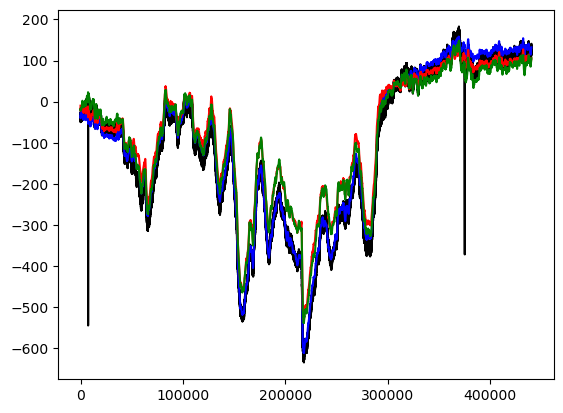

In [14]:
# visualize different filtered signals 
plt.plot(sig[:440000], color='black')
plt.plot(low_pass[:440000], color='blue')
plt.plot(high_pass[:440000], color='red')
plt.plot(sig_filt_all[:440000], color='green')

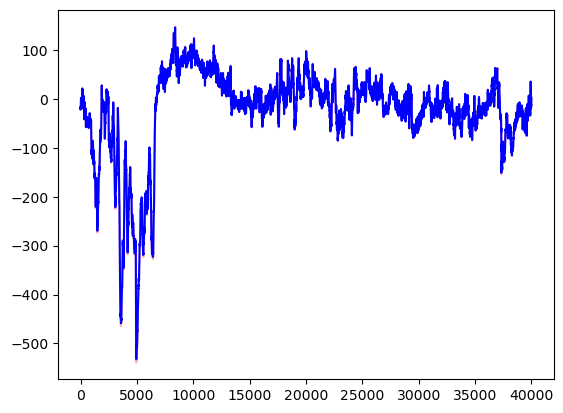

In [17]:
# visualize original and downsampled signals
plot_sec = 40
samples_ds = int(plot_sec * ds_hz)
samples_orig = int(plot_sec * fs)

ts1 = np.arange(samples_ds)
ts2 = np.linspace(0, samples_ds, samples_orig)

plt.plot(ts2, sig_filt_all[:samples_orig], 'r', alpha = 0.3)
plt.plot(ts1, ds_sig[:samples_ds], 'b')

In [18]:
# example bipolar re-referencing
ref1 = ds_sig - ds_c2

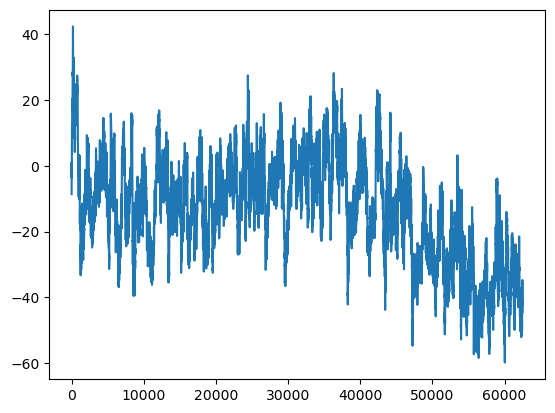

In [19]:
plt.plot(ref1)

In [97]:
# bipolar referencing 
ref1 = example_data['CRAW_01'] - example_data['CRAW_02']
ref2 = example_data['CRAW_01'] - example_data['CRAW_03']
ref3 = example_data['CRAW_01'] - example_data['CRAW_04']

ref4 = example_data['CMacro_RAW_03'] - example_data['CRAW_05']
ref5 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_01']
ref6 = example_data['CMacro_RAW_03'] - example_data['CMacro_RAW_02']

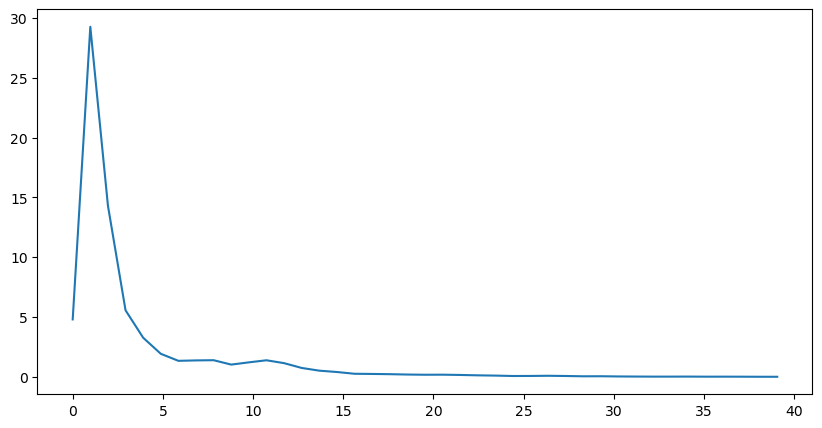

In [114]:
freq_mean1, psd_mean1 = compute_spectrum(ref1, ds_hz, method='welch', avg_type='mean', nperseg=1024)
# freq_mean2, psd_mean2 = compute_spectrum(ref1.flatten(), fs, method='welch', avg_type='mean', nperseg=1024)

new_freq1 = freq_mean1[freq_mean1<40]
new_psd1 = psd_mean1[freq_mean1<40]

# new_freq2 = freq_mean2[freq_mean2<120]
# new_psd2 = psd_mean2[freq_mean2<120]

plt.figure(figsize=(10, 5))
plt.plot(new_freq1, new_psd1, label='referenced_downsampled')
# plt.figure(figsize=(10, 5))
# plt.plot(freq_mean2, psd_mean2, label='referenced_original')
# plt.legend()

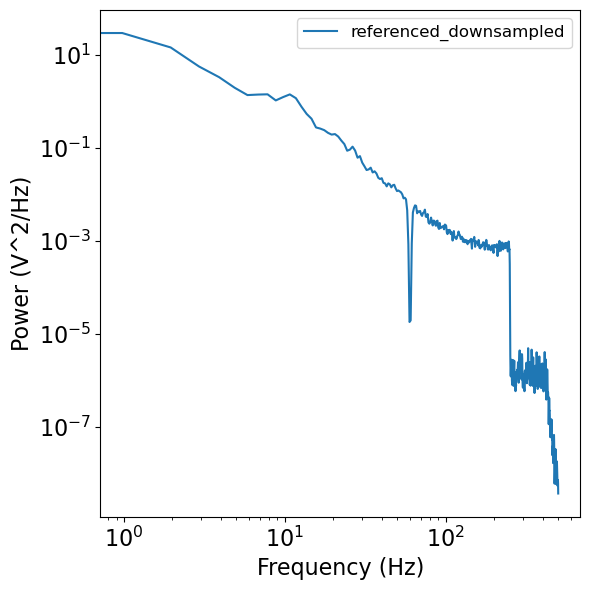

In [115]:
from neurodsp.plts.spectral import plot_power_spectra
plot_power_spectra(freq_mean1, psd_mean1, 'referenced_downsampled', log_freqs=True, log_powers=True)